In [1]:
%load_ext autoreload

import os
import sys
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn

module_path = os.path.abspath(os.path.join('../../py-conjugated/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import morphology_networks as net
import model_training as train
import model_testing as test
import physically_informed_loss_functions as pilf
import network_utils as nuts

torch.manual_seed(28)

# This notebook seeks to use all OPV processing conditions and morphological descriptors to predict device performance. 

## There will be 3 Neural Networks outlined, each with similar architecture, but varying inputs. This second NN will incorporate morphological information. However, morphological descriptors will be averaged per sample, similar to how device metrics are an average of performance across the active layer

### Inputs:
- DataFrame containing device processing conditions and their subsequent performance. This will similarly only include good devices

- DataFrame containing device-averaged morphology descriptors

### Outputs:
- Tensor of predicted performance for given processing conditions

In [2]:
#Take in data as a dataframe for easy preprocessing
total_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_train.xlsx')

test_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_test.xlsx')

print (f'total_df shape: {total_df.shape}')
print (f'test_df shape: {test_df.shape}')
total_df.head()

total_df shape: (26, 60)
test_df shape: (10, 60)


,Unnamed: 0,p1_fraction,p2_fraction,p3_fraction,p1_area_avg,p1_area_stdev,p1_filled_area_avg,p1_filled_area_stdev,p1_extent_avg,p1_extent_stdev,...,p3_Perim_avg,p3_Perim_stdev,PCE,VocL,Jsc,FF,Substrate,Device,Anneal_time,Anneal_temp
0,0,0.379892,0.741510,0.042227,0.747318,0.416992,0.747056,0.437669,0.371252,0.265335,...,0.385802,0.214615,0.833110,0.817731,0.950302,0.822343,4,2,15,100
1,1,0.299771,0.662438,0.354767,0.338403,0.119074,0.308619,0.108677,0.427280,0.413324,...,0.756401,0.786992,0.635534,0.739614,0.961763,0.685312,4,4,15,100
2,2,0.122273,0.555842,0.907236,0.637064,0.178141,0.581681,0.158955,0.172276,0.278782,...,0.771184,1.000000,0.863038,0.814898,0.947029,0.857800,4,7,15,100
3,3,0.019406,0.848362,0.504491,0.832873,0.498779,0.868876,0.509000,0.240255,0.557641,...,0.557095,0.404926,0.947300,0.806031,0.996387,0.904754,7,2,30,100
4,6,1.000000,0.000000,0.384999,0.271485,0.175114,0.267725,0.171034,0.309962,0.288716,...,0.000000,0.084425,0.865331,0.825047,0.903792,0.890140,1,3,5,100


In [3]:
# Hyper parameters
num_epochs = 100
batch_size = int(len(total_df['PCE'])*0.8) # 90% of x_train samples
learning_rate = 0.005

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
y_train = total_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted
x_train = total_df.drop(['PCE', 'VocL', 'Jsc', 'FF'], axis = 1)

y_test = test_df[['PCE', 'VocL', 'Jsc', 'FF']]
x_test = test_df.drop(['PCE', 'VocL', 'Jsc', 'FF'], axis = 1)

In [5]:
pce_train = y_train['PCE']
pce_test = y_test['PCE']
voc_train = y_train['VocL']
voc_test = y_test['VocL']
jsc_train = y_train['Jsc']
jsc_test = y_test['Jsc']
ff_train = y_train['FF']
ff_test = y_test['FF']

In [6]:
x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
pce_train_tensor = torch.tensor(pce_train.values.astype(np.float32))
voc_train_tensor = torch.tensor(voc_train.values.astype(np.float32))
jsc_train_tensor = torch.tensor(jsc_train.values.astype(np.float32))
ff_train_tensor = torch.tensor(ff_train.values.astype(np.float32))

#create tensor with features and targets
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, pce_train_tensor, voc_train_tensor, jsc_train_tensor, ff_train_tensor)
#create iterable dataset with batches
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = False)

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
pce_test_tensor = torch.tensor(pce_test.values.astype(np.float32))
voc_test_tensor = torch.tensor(voc_test.values.astype(np.float32))
jsc_test_tensor = torch.tensor(jsc_test.values.astype(np.float32))
ff_test_tensor = torch.tensor(ff_test.values.astype(np.float32))

test_tensor = torch.utils.data.TensorDataset(x_test_tensor, pce_test_tensor, voc_test_tensor, jsc_test_tensor, ff_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = False)

Now that the data, model, training, and evaluating are all set up, let's actually use everything

In [7]:
# takes in 8 features (anneal time, anneal temp, MajorAL, MinorAL, Ecc, Orient, Perim, GMM_label) 
# predicts 4 metrics (PCE, Voc, Jsc, FF)
in_dims = int(x_train_tensor.size(1)) #number of x channels
out_dims = y_test.shape[1] #number of predicted features

model = net.OPV_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)
model.apply(nuts.init_weights)
# print(model)

#define the optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [8]:
%autoreload

#empty list to hold loss per epoch
train_epoch_losses = []
pce_train_epoch_losses = []
voc_train_epoch_losses = []
jsc_train_epoch_losses = []
ff_train_epoch_losses = []

test_epoch_losses = []
pce_test_epoch_losses = []
voc_test_epoch_losses = []
jsc_test_epoch_losses = []
ff_test_epoch_losses = []

pce_test_epoch_accuracies = []
voc_test_epoch_accuracies = []
jsc_test_epoch_accuracies = []
ff_test_epoch_accuracies = []

save_epochs = np.arange(0, num_epochs, 5)

for epoch in range(num_epochs):
    print('On epoch ', epoch)
    
    save_dir = "/Users/wesleytatum/Desktop/model_states/OPV_NN2/"
    model_name = "OPV_NN2"
    model_path = save_dir+model_name+'*.pt'
    if epoch < 10:
        save_path = save_dir + model_name + '_epoch0' + str(epoch) + '.pt'
    else:
        save_path = save_dir + model_name + '_epoch' + str(epoch) + '.pt'
        
    if glob.glob(model_path) != []:
        model_states = glob.glob(model_path)
        model_states = sorted(model_states)
        previous_model = model_states[-1]    
        
        model, optimizer = nuts.load_trained_model(previous_model, model, optimizer)
    
    model, train_loss, pce_train_loss, voc_train_loss, jsc_train_loss, ff_train_loss = train.train_OPV_df_model(model = model,
                                                                                                         training_data_set = training_data_set,
                                                                                                         optimizer = optimizer)
    train_epoch_losses.append(train_loss)
    pce_train_epoch_losses.append(pce_train_loss)
    voc_train_epoch_losses.append(voc_train_loss)
    jsc_train_epoch_losses.append(jsc_train_loss)
    ff_train_epoch_losses.append(ff_train_loss)
    
    test_loss, pce_test_loss, voc_test_loss, jsc_test_loss, ff_test_loss, pce_acc, voc_acc, jsc_acc, ff_acc = test.eval_OPV_df_model(model = model,
                                                                                                                                    testing_data_set = testing_data_set)
    test_epoch_losses.append(test_loss)
    pce_test_epoch_losses.append(pce_test_loss)
    voc_test_epoch_losses.append(voc_test_loss)
    jsc_test_epoch_losses.append(jsc_test_loss)
    ff_test_epoch_losses.append(ff_test_loss)
    
    pce_test_epoch_accuracies.append(pce_acc)
    voc_test_epoch_accuracies.append(voc_acc)
    jsc_test_epoch_accuracies.append(jsc_acc)
    ff_test_epoch_accuracies.append(ff_acc)
 
    nuts.save_trained_model(save_path, epoch, model, optimizer)    
    

On epoch  0
Total Epoch Testing Loss = 9.69261360168457
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 65.14277085661888
                              Jsc = 318.87074768543243
                              FF = 79.69531461596489
On epoch  1
Total Epoch Testing Loss = 2.3389084339141846
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 65.35704503767192
                              Jsc = 62.742292173206806
                              FF = 100.0
On epoch  2
Total Epoch Testing Loss = 2.3641176223754883
Total Epoch Testing MAPE: PCE = 98.24969947338104
                              Voc = 56.36226838454604
                              Jsc = 99.16525363922119
                              FF = 78.65191161632538
On epoch  3
Total Epoch Testing Loss = 2.15916109085083
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 79.11295376718044
                              Jsc = 67.71052181720734
                           

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Plea

On epoch  4
Total Epoch Testing Loss = 2.5446794033050537
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 102.79493093490602
                              Jsc = 85.70690095424652
                              FF = 63.012169897556305
On epoch  5
Total Epoch Testing Loss = 2.3736319541931152
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 104.22606647014618
                              Jsc = 81.2115228176117
                              FF = 56.93969249725341
On epoch  6
Total Epoch Testing Loss = 2.100794792175293
Total Epoch Testing MAPE: PCE = 98.36611449718475
                              Voc = 102.42160618305208
                              Jsc = 70.10356426239014
                              FF = 42.59115278720856
On epoch  7
Total Epoch Testing Loss = 1.5351446866989136
Total Epoch Testing MAPE: PCE = 89.04172897338867
                              Voc = 87.04474478960037
                              Jsc = 50.70196002721786

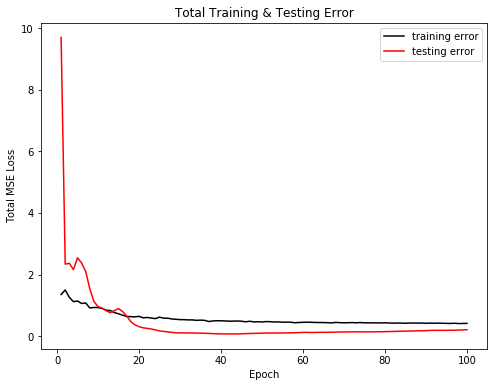

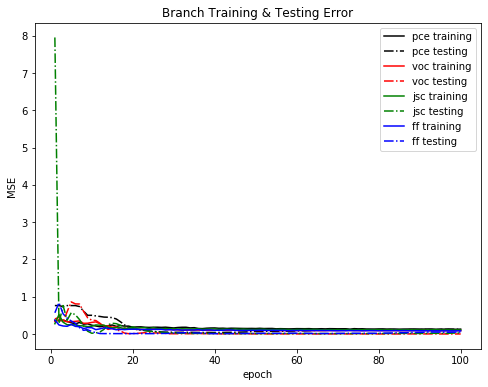

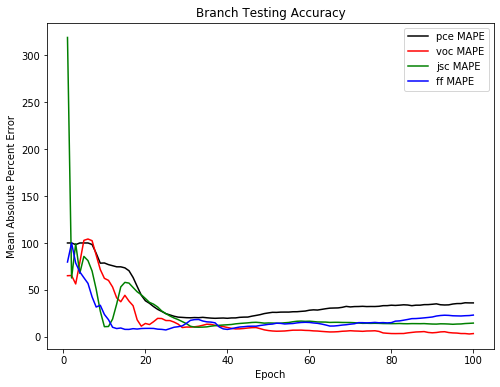

In [9]:
%autoreload
epochs = np.arange(1, (num_epochs+1), 1)

nuts.plot_OPV_df_loss(epochs, train_epoch_losses, test_epoch_losses,
                     pce_train_epoch_losses, pce_test_epoch_losses,
                     voc_train_epoch_losses, voc_test_epoch_losses,
                     jsc_train_epoch_losses, jsc_test_epoch_losses,
                     ff_train_epoch_losses, ff_test_epoch_losses)

nuts.plot_OPV_df_accuracies(epochs, pce_test_epoch_accuracies, voc_test_epoch_accuracies, 
                           jsc_test_epoch_accuracies, ff_test_epoch_accuracies)

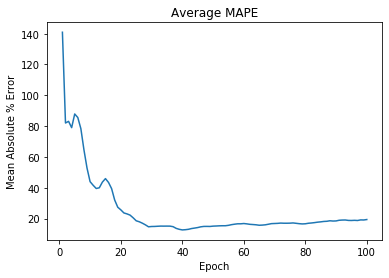

In [10]:
avg_acc = []
for p, v, j, f in zip(pce_test_epoch_accuracies, voc_test_epoch_accuracies,
                      jsc_test_epoch_accuracies, ff_test_epoch_accuracies):
    
    acc = (p+v+j+f)/4
    avg_acc.append(acc)
    
fig, ax = plt.subplots()
plt.plot(epochs, avg_acc)
plt.title('Average MAPE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute % Error')
plt.show()

In [11]:
potential_models = avg_acc[:45]

min_mape = min(potential_models)

best_acc_indx = []
for acc in potential_models:
    if acc == min_mape:
        best_acc_indx.append(potential_models.index(acc))
    else:
        pass

In [12]:
if best_acc_indx[0] < 10:
    epoch = f'0{best_acc_indx[0]}'
else:
    epoch = f'{best_acc_indx[0]}'

print(epoch)

best_model_path = save_dir + model_name + '_epoch' + epoch + '.pt'
best_model = net.OPV_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)

best_model, best_optimizer = nuts.load_trained_model(best_model_path, best_model, optimizer)

39


In [13]:
%autoreload

best_model.eval()

with torch.no_grad():
    for inputs, pce_labels, voc_labels, jsc_labels, ff_labels in testing_data_set:
        inputs = inputs.to(device)
        pce_labels = pce_labels.to(device)
        voc_labels = voc_labels.to(device)
        jsc_labels = jsc_labels.to(device)
        ff_labels = ff_labels.to(device)

        PCE_out, Voc_out, Jsc_out, FF_out = best_model(inputs)
        

mape = pilf.reg_MAPE()

pce_mse = mean_squared_error(PCE_out, pce_labels)
pce_r2 = r2_score(PCE_out, pce_labels)
pce_mape = mape.forward(PCE_out, pce_labels)

print(f'mse = {pce_mse}, mape = {pce_mape}, r2 = {pce_r2}')

voc_mse = mean_squared_error(Voc_out, voc_labels)
voc_r2 = r2_score(Voc_out, voc_labels)
voc_mape = mape.forward(Voc_out, voc_labels)

print(f'mse = {voc_mse}, mape = {voc_mape}, r2 = {voc_r2}')

jsc_mse = mean_squared_error(Jsc_out, jsc_labels)
jsc_r2 = r2_score(Jsc_out, jsc_labels)
jsc_mape = mape.forward(Jsc_out, jsc_labels)

print(f'mse = {jsc_mse}, mape = {jsc_mape}, r2 = {jsc_r2}')

ff_mse = mean_squared_error(FF_out, ff_labels)
ff_r2 = r2_score(FF_out, ff_labels)
ff_mape = mape.forward(FF_out, ff_labels)

print(f'mse = {ff_mse}, mape = {ff_mape}, r2 = {ff_r2}')

mse = 0.03858184814453125, mape = tensor([19.7793]), r2 = -381.88561855348553
mse = 0.010594341903924942, mape = tensor([9.9903]), r2 = -1.2872431635022399
mse = 0.01593652553856373, mape = tensor([12.8798]), r2 = -251.09836299819656
mse = 0.010462949052453041, mape = tensor([7.9226]), r2 = -68.6531157723919


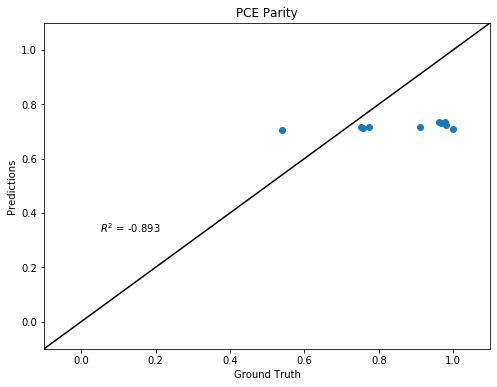

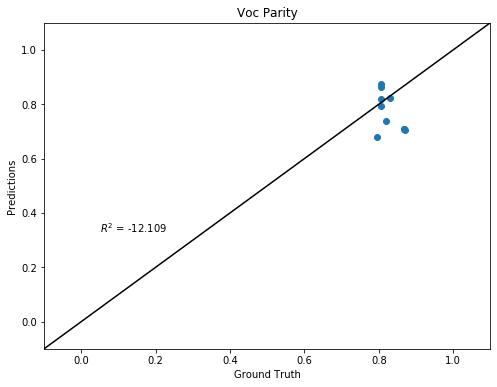

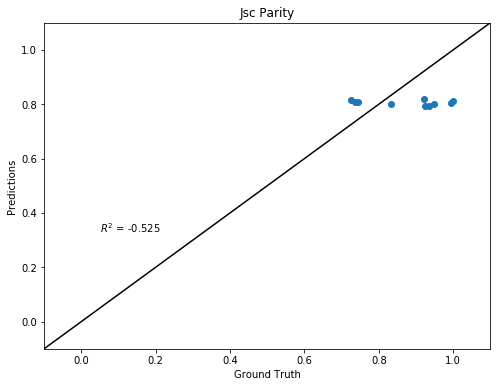

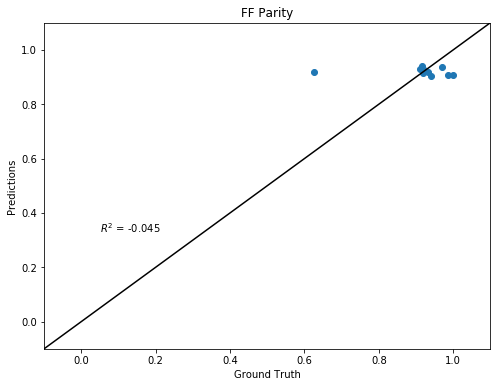

In [14]:
%autoreload

nuts.plot_OPV_parity(pce_labels, PCE_out, voc_labels, Voc_out, jsc_labels, Jsc_out, ff_labels, FF_out)